# Calculating Polygenic Risk Scores per Group
- **Project:** GP2 AFR-AAC meta-GWAS 
- **Version:** Python/3.9
- **Status:** COMPLETE
- **Started:** 25-FEB-2023
- **Last Updated:** 22-MAR-2023
    - **Update Description:** Run GLM 

## Notebook Overview
- Conducting PRS on cohorts: Pulling the 90 European variants from Nalls et al., 2019 and using European betas (AAC betas in notebook 12)

### CHANGELOG
- 25-FEB-2023: Notebook started 
- 22-MAR-2023: Run GLM

---
# Data Overview 

| ANCESTRY |     DATASET     | CASES | CONTROLS |  TOTAL  |           ARRAY           |                NOTES                |
|:--------:|:---------------:|:-----:|:--------:|:-------------------------:|:---------------------------------------------------------------------------------------------------------------:|:-----------------------------------:|
|    AFR   | IPDGC – Nigeria |  304  |    285   |   589   |         NeuroChip         | . | 
|    AFR   |  GP2  |  711  |   1,011  |  1,722  |        NeuroBooster       | . |
|    AAC   |  GP2 |  185  |   1,149  |  1,334  |        NeuroBooster       | . | 
|    AAC   |     23andMe     |  288  |  193,985 | 194,273 | Omni Express & GSA & 550k |        Just summary statistics       |

# Getting Started

## Importing packages

In [3]:
## Import the necessary packages 
import os
import numpy as np
import pandas as pd
import gwaslab as gl
import math
import sys
import subprocess
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numbers

## Print out package versions
## Getting packages loaded into this notebook and their versions to allow for reproducibility
    # Repurposed code from stackoverflow here: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

## Import packages 
import pkg_resources
import types
from datetime import date
today = date.today()
date = today.strftime("%d-%b-%Y").upper()

## Define function 
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different imported names vs. system/pip names
        # Unfortunately, there is no systematic way to get pip names from a package's imported name. You'll have to add exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

## Get a list of packages imported 
imports = list(set(get_imports()))

# The only way I found to get the version of the root package from only the name of the package is to cross-check the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

## Print out packages and versions 
print(f"PACKAGE VERSIONS ({date})")
for r in requirements:
    print("\t{}=={}".format(*r))

PACKAGE VERSIONS (22-MAR-2023)
	gwaslab==3.3.20
	matplotlib==3.5.3
	numpy==1.23.5
	pandas==1.5.3
	scikit-learn==1.2.2
	scipy==1.8.1
	seaborn==0.12.2
	statsmodels==0.13.5


# Define necessary functions

In [4]:
## Make a function to convert model to dataframe of values to print out 
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    stderr = results.bse
    # conf_lower = results.conf_int()[0]
    # conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"PVAL":pvals,
                               "BETA":coeff,
                               "STDERR":stderr
                               # "CONF_LOWER":conf_lower,
                               # "CONF_HIGHER":conf_higher
                                })

    # Calculate the odds ratios and the CIs 
    results_df['OR'] = results_df['BETA'].apply(np.exp)
    results_df['OR-95LOWERCI'] = results_df['OR'] - 1.96 * results_df['STDERR']
    results_df['OR-95UPPERCI'] = results_df['OR'] + 1.96 * results_df['STDERR']
    
    # Reordering...
    results_df = results_df[["PVAL","BETA", "STDERR", "OR", "OR-95LOWERCI", "OR-95UPPERCI"]].sort_values(by = 'PVAL')
    return results_df

# IPDGC – Nigeria – AFR - NC

## Extract 90 variants + Calculate Scores

In [ ]:
%%bash

module load plink

plink2 \
--bfile ${NG_AFR_NEUROCHIP} \
--score ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt list-variants \
--out ${WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI

## Calculate Dosages

In [ ]:
%%bash 

# Create transposed data with dosages

plink2 \
--bfile ${NG_AFR_NEUROCHIP} \
--extract ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt \
--export A --export-allele ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt \
--out ${WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-transpose

## Standardize + Visualize + Save PRS

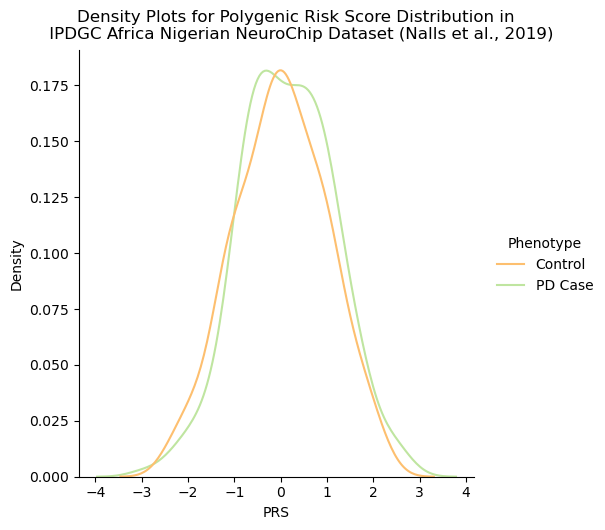

In [7]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
cov_df = pd.read_csv(f"{WORK_DIR}/data/AFR/NIGERIAN-NC/NIGERIAN-NEUROCHIP-AFR-covariate-wAGE-FEB2023.txt", sep="\t")
transpose_df = pd.read_csv(f"{WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")

# Standardize with the HC's distribution of PRS
hc_mean = np.mean(merged_df2[merged_df2.PHENO==1].PRS)
hc_sd = np.std(merged_df2[merged_df2.PHENO==1].PRS)
merged_df2['PRS'] = (merged_df2.PRS - hc_mean)/hc_sd
merged_df2.reset_index(inplace=True)

# Add case/control column for the legend
merged_df2['Phenotype'] = np.where(merged_df2['PHENO'] == 1, "Control", "PD Case")

## Plot PRS distribution 
g = sns.displot(merged_df2, x="PRS", hue="Phenotype", kind="kde", palette=sns.color_palette('Spectral', n_colors=2))
g.fig.suptitle('Density Plots for Polygenic Risk Score Distribution in \n IPDGC Africa Nigerian NeuroChip Dataset (Nalls et al., 2019)', y = 1.05)
g.savefig(f"{WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-PRS-Density.png", dpi=300)

## Save PRS 
prs_df.to_csv(f"{WORK_DIR}/data/PRS/NIGERIAN-NEUROCHIP-AFR-EUR90LOCI-PRS.csv",index=False)

## T-test 

In [8]:
# PD vs healthy control
stats.ttest_ind(merged_df2.PRS[merged_df2.PHENO==2], merged_df2.PRS[merged_df2.PHENO==1])

Ttest_indResult(statistic=1.7100953911700105, pvalue=0.0877766648110769)

## Binomial GLM Regression

In [9]:
# Keep only columns needed for regression
merged_df3 = merged_df2[['IID', 'PRS', 'SEX', 'PHENO', 'PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'AGE_ANALYSIS']].copy()

# Change pheno to 0/1
merged_df3['PHENO'] = merged_df3['PHENO'].replace({1: 0, 2: 1})

# Standardize continuous predictors by creating a z-score distribution
scaler = StandardScaler()
cols_to_standardize = ['PRS', 'AGE_ANALYSIS', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
merged_df3[cols_to_standardize] = scaler.fit_transform(merged_df3[cols_to_standardize])

# Binomial GLM to see if PRS predicts for PHENO (PD vs control)
formula = "PHENO ~ PRS + AGE_ANALYSIS + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
model = smf.glm(formula=formula, data=merged_df3, family=sm.families.Binomial(), missing='drop').fit()
print(model.summary())

# Get values
results_df = results_summary_to_dataframe(model)
results_df

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  PHENO   No. Observations:                  589
Model:                            GLM   Df Residuals:                      575
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -364.14
Date:                Wed, 22 Mar 2023   Deviance:                       728.28
Time:                        22:59:38   Pearson chi2:                     581.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1382
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4548      0.270      1.685   

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
AGE_ANALYSIS,3.908329e-12,-0.708668,0.102107,0.492300,0.292170,0.692429
PC1,5.528729e-03,0.306106,0.110328,1.358126,1.141882,1.574369
Intercept,9.193427e-02,0.454806,0.269870,1.575868,1.046924,2.104813
SEX,1.695268e-01,-0.268559,0.195497,0.764480,0.381307,1.147654
PC4,2.158278e-01,-0.247629,0.200072,0.780649,0.388507,1.172791
PRS,2.224303e-01,0.112198,0.091959,1.118735,0.938495,1.298974
PC7,2.330816e-01,0.124451,0.104365,1.132526,0.927971,1.337082
PC2,3.779342e-01,-0.088428,0.100291,0.915369,0.718798,1.111940
PC8,4.347710e-01,0.077414,0.099115,1.080490,0.886224,1.274755
PC9,4.604401e-01,-0.083581,0.113235,0.919817,0.697877,1.141756


In [10]:
results_df.loc[['PRS']]

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
PRS,0.22243,0.112198,0.091959,1.118735,0.938495,1.298974


## Results Summary 

<div class="alert alert-block alert-info">
<b>Results for IPDGC - Nigerian - NeuroChip:</b> 
<ul>
    <li>73 out of 90 variants were found</li>
    <li>T-test not significant between case and control PRS (P=0.088)</li>
    <li>PRS does not predict status between PD and healthy controls (P=2.22E-01; BETA=0.112; SE=0.092; OR=1.119; CI=0.938495-1.298974; GLM Binomial regression)</li>
</ul>
</div>

# GP2 – AFR (public AFR+Nigerian NB)

## Extract 90 variants + Calculate Scores

In [ ]:
%%bash

module load plink

plink2 \
--bfile ${UPDATED_GP2_v4_AFR} \
--score ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt list-variants \
--out ${WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI

## Calculate Dosages

In [ ]:
%%bash 

# Create transposed data with dosages

plink2 \
--bfile ${UPDATED_GP2_v4_AFR} \
--extract ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt \
--export A --export-allele ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt \
--out ${WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-transpose

## Standardize + Visualize + Save PRS

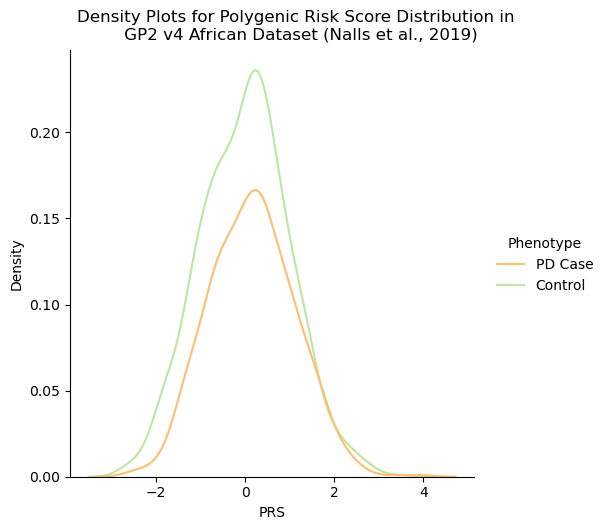

In [14]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
cov_df = pd.read_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_wAGE_FEB2023.txt", sep="\t")
transpose_df = pd.read_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")

# Standardize with the HC's distribution of PRS
hc_mean = np.mean(merged_df2[merged_df2.PHENO==1].PRS)
hc_sd = np.std(merged_df2[merged_df2.PHENO==1].PRS)
merged_df2['PRS'] = (merged_df2.PRS - hc_mean)/hc_sd
merged_df2.reset_index(inplace=True)

# Add case/control column for the legend
merged_df2['Phenotype'] = np.where(merged_df2['PHENO'] == 1, "Control", "PD Case")

## Plot PRS distribution 
g = sns.displot(merged_df2, x="PRS", hue="Phenotype", kind="kde", palette=sns.color_palette('Spectral', n_colors=2))
g.fig.suptitle('Density Plots for Polygenic Risk Score Distribution in \n GP2 v4 African Dataset (Nalls et al., 2019)', y = 1.05)
g.savefig(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-PRS-Density.png", dpi=300)

## Save PRS 
prs_df.to_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AFR-wNIGERIAN-NB-EUR90LOCI-PRS.csv",index=False)

## T-test 

In [15]:
# PD vs healthy control
stats.ttest_ind(merged_df2.PRS[merged_df2.PHENO==2], merged_df2.PRS[merged_df2.PHENO==1])

Ttest_indResult(statistic=3.2815521396311986, pvalue=0.0010530449839916153)

## Binomial GLM Regression

In [16]:
# Keep only columns needed for regression
merged_df3 = merged_df2[['IID', 'PRS', 'SEX', 'PHENO', 'PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'AGE_ANALYSIS']].copy()

# Change pheno to 0/1
merged_df3['PHENO'] = merged_df3['PHENO'].replace({1: 0, 2: 1})

# Standardize continuous predictors by creating a z-score distribution
scaler = StandardScaler()
cols_to_standardize = ['PRS', 'AGE_ANALYSIS', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
merged_df3[cols_to_standardize] = scaler.fit_transform(merged_df3[cols_to_standardize])

# Binomial GLM to see if PRS predicts for PHENO (PD vs control)
formula = "PHENO ~ PRS + AGE_ANALYSIS + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
model = smf.glm(formula=formula, data=merged_df3, family=sm.families.Binomial(), missing='drop').fit()
print(model.summary())

# Get values
results_df = results_summary_to_dataframe(model)
results_df

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  PHENO   No. Observations:                 1722
Model:                            GLM   Df Residuals:                     1708
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -999.33
Date:                Wed, 22 Mar 2023   Deviance:                       1998.7
Time:                        23:00:20   Pearson chi2:                 1.70e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1773
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1255      0.166      0.757   

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
AGE_ANALYSIS,2.684746e-15,-0.449896,0.056915,0.637694,0.526142,0.749247
PC1,2.997920e-08,0.486365,0.087767,1.626394,1.454371,1.798417
PC8,5.820352e-08,-0.438815,0.080899,0.644800,0.486238,0.803362
PRS,1.058815e-05,0.241808,0.054896,1.273549,1.165952,1.381146
SEX,1.625149e-04,-0.436056,0.115630,0.646582,0.419946,0.873217
PC7,2.593730e-03,0.185417,0.061556,1.203721,1.083072,1.324370
PC6,2.176538e-01,0.066601,0.054025,1.068869,0.962981,1.174758
PC3,4.264830e-01,-0.044407,0.055843,0.956564,0.847113,1.066016
Intercept,4.487980e-01,0.125482,0.165670,1.133695,0.808981,1.458408
PC9,4.848030e-01,-0.038491,0.055097,0.962240,0.854250,1.070231


In [93]:
results_df.loc[['PRS']]

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
PRS,0.000011,0.241808,0.054896,1.273549,1.165952,1.381146


In [ ]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENO']==1, "CONTROL", "PD")
merged_df2['Sex'] = np.where(merged_df2['SEX']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains('^chr')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')

## Histogram Plot to Visualize Mean Effect

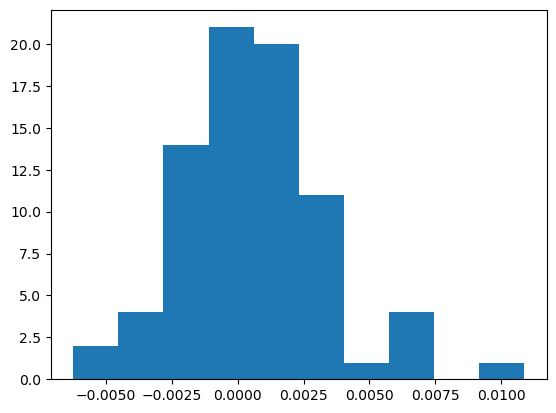

,SNP,A1,BETA,CONTROL,PD,FREQ_DIFFERENCE,EFFECT_MEAN
chr4:89704960:G:A_A,chr4:89704960:G:A,A,-0.2774,1.420261,1.32808,-0.092181,0.025571


In [18]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()
snp_beta_df[snp_beta_df.EFFECT_MEAN>0.02]

In [19]:
# Adjusting by the variant with the largest effect size
df = merged_df2[merged_df2.STATUS.isin(['CONTROL', 'PD'])].copy()
Y = df.PRS
X = df[['chr4:89704960:G:A_A']].copy()
X['STATUS'] = (df.STATUS=='CONTROL')*1
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop').fit()
print(model.summary())
adjusted_results_df = results_summary_to_dataframe(model)
adjusted_results_df

                            OLS Regression Results                            
Dep. Variable:                    PRS   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     124.5
Date:                Wed, 22 Mar 2023   Prob (F-statistic):           3.64e-51
Time:                        23:09:47   Log-Likelihood:                -2269.1
No. Observations:                1695   AIC:                             4544.
Df Residuals:                    1692   BIC:                             4560.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8687    

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
chr4:89704960:G:A_A,4.762023e-50,-0.533540,0.034696,0.586525,0.518521,0.654529
const,5.886849e-48,0.868720,0.057842,2.383858,2.270488,2.497227
STATUS,1.432905e-02,-0.112029,0.045699,0.894018,0.804448,0.983589


In [20]:
adjusted_results_df.loc[['STATUS']]

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
STATUS,0.014329,-0.112029,0.045699,0.894018,0.804448,0.983589


## Results Summary 

<div class="alert alert-block alert-info">
<b>Results for GP2 – AFR:</b> 
<ul>
    <li>79 out of 90 variants were found</li>
    <li>T-test is significant between case and control PRS (P=0.00105)</li>
    <li>PRS does significantly predict status between PD and healthy controls (P=1.059E-05; BETA=0.241808; SE=0.054896; OR=1.273549; CI=1.165952-1.381146; GLM Binomial regression)</li>
    <li>The variant with the largest effect size was chr4:89704960:G:A_A (SNCA) AKA rs356182</li>
    <li>After adjusting for the SNCA variant (rs356182), PRS differences between PD and controls were still significant (P=0.014329; BETA=-0.112029; SE=0.045699; OR=0.894018; CI=0.804448-0.983589; OLS regression)</li>
</ul>
</div>


# GP2 – AAC 

## Extract 90 variants + Calculate Scores

In [ ]:
%%bash

module load plink

plink2 \
--bfile ${UPDATED_GP2_v4_AAC} \
--score ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt list-variants \
--out ${WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI

## Calculate Dosages

In [ ]:
%%bash 

# Create transposed data with dosages

plink2 \
--bfile ${UPDATED_GP2_v4_AAC} \
--extract ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt \
--export A --export-allele ${WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt \
--out ${WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-transpose

## Standardize + Visualize + Save PRS

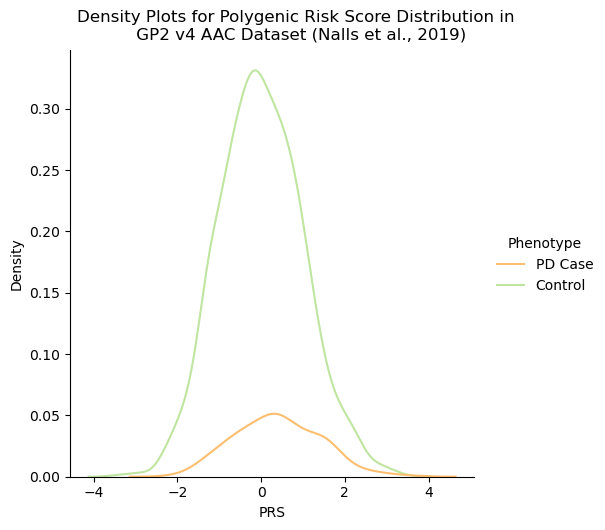

In [23]:
## Read in PRS
prs_df = pd.read_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI.sscore", delim_whitespace=True, usecols=['IID', 'SCORE1_AVG'])
prs_df.columns=['IID','PRS']

## Read in the covariate file and the transposed PLINK .raw file with dosages
cov_df = pd.read_csv(f"{WORK_DIR}/data/masterfile_updated_GP2_v4_covariateFile_wAGE_FEB2023.txt", sep="\t")
transpose_df = pd.read_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-transpose.raw", sep='\t').drop(columns=['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'])

## Merge dataframes
merged_df1 = pd.merge(prs_df, cov_df, on="IID", how="left")
merged_df2 = pd.merge(merged_df1, transpose_df, on="IID", how="left")

# Standardize with the HC's distribution of PRS
hc_mean = np.mean(merged_df2[merged_df2.PHENO==1].PRS)
hc_sd = np.std(merged_df2[merged_df2.PHENO==1].PRS)
merged_df2['PRS'] = (merged_df2.PRS - hc_mean)/hc_sd
merged_df2.reset_index(inplace=True)

# Add case/control column for the legend
merged_df2['Phenotype'] = np.where(merged_df2['PHENO'] == 1, "Control", "PD Case")

## Plot PRS distribution 
g = sns.displot(merged_df2, x="PRS", hue="Phenotype", kind="kde", palette=sns.color_palette('Spectral', n_colors=2))
g.fig.suptitle('Density Plots for Polygenic Risk Score Distribution in \n GP2 v4 AAC Dataset (Nalls et al., 2019)', y = 1.05)
g.savefig(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-PRS-Density.png", dpi=300)

## Save PRS 
prs_df.to_csv(f"{WORK_DIR}/data/PRS/UPDATED-GP2-v4-AAC-EUR90LOCI-PRS.csv",index=False)

## T-test

In [24]:
# PD vs healthy control
stats.ttest_ind(merged_df2.PRS[merged_df2.PHENO==2], merged_df2.PRS[merged_df2.PHENO==1])

Ttest_indResult(statistic=4.946476604252489, pvalue=8.520061299263376e-07)

## Binomial GLM Regression

In [25]:
# Keep only columns needed for regression
merged_df3 = merged_df2[['IID', 'PRS', 'SEX', 'PHENO', 'PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'AGE_ANALYSIS']].copy()

# Change pheno to 0/1
merged_df3['PHENO'] = merged_df3['PHENO'].replace({1: 0, 2: 1})

# Standardize continuous predictors by creating a z-score distribution
scaler = StandardScaler()
cols_to_standardize = ['PRS', 'AGE_ANALYSIS', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
merged_df3[cols_to_standardize] = scaler.fit_transform(merged_df3[cols_to_standardize])

# Binomial GLM to see if PRS predicts for PHENO (PD vs control)
formula = "PHENO ~ PRS + AGE_ANALYSIS + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"
model = smf.glm(formula=formula, data=merged_df3, family=sm.families.Binomial(), missing='drop').fit()
print(model.summary())

# Get values
results_df = results_summary_to_dataframe(model)
results_df

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  PHENO   No. Observations:                 1334
Model:                            GLM   Df Residuals:                     1320
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -465.55
Date:                Wed, 22 Mar 2023   Deviance:                       931.09
Time:                        23:16:49   Pearson chi2:                 1.48e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1016
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9116      0.267     -3.408   

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
AGE_ANALYSIS,1.886396e-16,-0.668429,0.081228,0.512513,0.353307,0.671719
SEX,9.272598e-06,-0.761994,0.171873,0.466735,0.129864,0.803606
PRS,4.371506e-05,0.363686,0.088988,1.438623,1.264206,1.613039
Intercept,6.541002e-04,-0.911641,0.267490,0.401864,-0.122416,0.926145
PC5,1.209038e-03,-0.355522,0.109839,0.700808,0.485522,0.916093
PC1,3.118487e-02,-0.292741,0.135861,0.746215,0.479927,1.012503
PC9,2.430166e-01,-0.103558,0.088702,0.901624,0.727768,1.075480
PC4,3.245283e-01,-0.093988,0.095400,0.910294,0.723309,1.097278
PC7,3.362680e-01,-0.095114,0.098915,0.909270,0.715396,1.103144
PC10,4.454430e-01,0.068746,0.090095,1.071164,0.894577,1.247750


In [26]:
results_df.loc[['PRS']]

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
PRS,0.000044,0.363686,0.088988,1.438623,1.264206,1.613039


In [ ]:
## Recode status
merged_df2['STATUS'] = np.where(merged_df2['PHENO']==1, "CONTROL", "PD")
merged_df2['Sex'] = np.where(merged_df2['SEX']==1, "Male", "Female")

## Aggregate the information
pivot_df = merged_df2.loc[
    merged_df2.STATUS.isin(['CONTROL', 'PD']),
    ['STATUS']+list(merged_df2.columns[merged_df2.columns.str.contains('^chr')])
].pivot_table(
    index=['STATUS'],
    aggfunc=['mean']
).T.reset_index().drop(columns='level_0').set_index('level_1')

## Calculate the frequency difference per variant between cases and controls
pivot_df['FREQ_DIFFERENCE'] = pivot_df['PD'] - pivot_df['CONTROL']

## Read in the full Nalls et al., scoring file
scores = pd.read_csv(f"{WORK_DIR}/data/PRS/GP2_Nalls2019_hg38.txt", sep='\t', header=None, names=['SNP', 'A1', 'BETA'])
scores.index = scores['SNP'] + '_' + scores['A1']

## Merge pivot table and scores file to calculate mean effect
snp_beta_df = pd.concat([scores,pivot_df],axis=1)
snp_beta_df['EFFECT_MEAN'] = snp_beta_df['FREQ_DIFFERENCE']*snp_beta_df['BETA']
snp_beta_df.sort_values('EFFECT_MEAN')

## Histogram Plot to Visualize Mean Effect

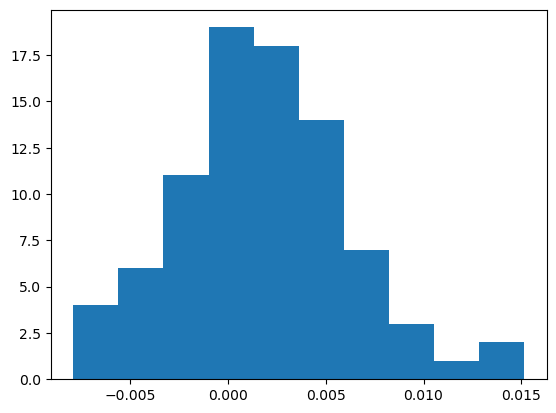

,SNP,A1,BETA,CONTROL,PD,FREQ_DIFFERENCE,EFFECT_MEAN
chr4:89704960:G:A_A,chr4:89704960:G:A,A,-0.2774,1.370757,1.227027,-0.14373,0.039871


In [28]:
plt.hist(snp_beta_df.EFFECT_MEAN[snp_beta_df.EFFECT_MEAN<0.02], bins=10)
plt.show()
snp_beta_df[snp_beta_df.EFFECT_MEAN>0.02]

The variant with the largest effect size was

chr4:89704960:G:A_A (*SNCA*) AKA rs356182

### Adjusting by intronic *SNCA* variant

In [29]:
# Adjusting by the variant with the largest effect size
df = merged_df2[merged_df2.STATUS.isin(['CONTROL', 'PD'])].copy()
Y = df.PRS
X = df[['chr4:89704960:G:A_A']].copy()
X['STATUS'] = (df.STATUS=='CONTROL')*1
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop').fit()
print(model.summary())
adjusted_results_df = results_summary_to_dataframe(model)
adjusted_results_df

                            OLS Regression Results                            
Dep. Variable:                    PRS   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     112.5
Date:                Wed, 22 Mar 2023   Prob (F-statistic):           7.08e-46
Time:                        23:17:06   Log-Likelihood:                -1803.4
No. Observations:                1334   AIC:                             3613.
Df Residuals:                    1331   BIC:                             3628.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0443    

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
chr4:89704960:G:A_A,7.827122e-42,-0.530894,0.037827,0.588079,0.513938,0.662220
const,2.262700e-34,1.044335,0.083017,2.841508,2.678794,3.004222
STATUS,2.211449e-05,-0.316608,0.074363,0.728616,0.582864,0.874368


In [30]:
adjusted_results_df.loc[['STATUS']]

,PVAL,BETA,STDERR,OR,OR-95LOWERCI,OR-95UPPERCI
STATUS,0.000022,-0.316608,0.074363,0.728616,0.582864,0.874368


## Results Summary 

<div class="alert alert-block alert-info">
<b>Results for GP2 – AAC:</b> 
<ul>
    <li>86 out of 90 variants were found</li>
    <li>T-test is significant between case and control PRS (P=8.52E-07)</li>
    <li>PRS does significantly predict status between PD and healthy controls (P=4.372E-05; BETA=0.3637; SE=0.089; OR=1.439; CI=1.264206-1.613039;  GLM Binomial regression)</li>
    <li>The variant with the largest effect size was chr4:89704960:G:A_A (SNCA) AKA rs356182</li>
    <li>After adjusting for the SNCA variant (rs356182), PRS differences between PD and controls were still significant (P=2.211449E-05; BETA=-0.316608; SE=0.074363; OR=0.728616; CI=0.582864-0.874368; OLS regression)</li>
</ul>
</div>